In [1]:
!pip install --user nltk
!python -m nltk.downloader punkt

touch: cannot touch '/usr/local/cuda/compat/.440.36.co2-slurm-ng02.checked': Read-only file system
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
touch: cannot touch '/usr/local/cuda/compat/.440.36.co2-slurm-ng02.checked': Read-only file system
/usr/lib/python3.6/runpy.py:125: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package punkt to
[nltk_data]     /users/tweetcontextualization/acouprie/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
import os
import json
import string
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import special
from collections import Counter#, OrderedDict
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords

# constants
ROOT_FOLDER = "/projets/prevision/"
DATASET_ROOT_FOLDER = ROOT_FOLDER + "datasets/ukenvironmental/"
IF_IDF_FILE_NAME = ROOT_FOLDER + "output/ukenvironmental/if_idf_output.csv"
JSON_FILE_NAME = DATASET_ROOT_FOLDER + "all_sentences.json"

if not os.path.isfile(JSON_FILE_NAME):
    !python "/projets/prevision/modules/ukenvironmental/format_dataset_to_json.py"

In [3]:
# DF_IDF
def term_frequency(occurence, total_words_number):
    return occurence / total_words_number

def inverse_document_frequency(total_docs_number, docs_numbers_with_word):
    return math.log(total_docs_number / docs_numbers_with_word)

def tf_idf(word_occurence, total_words_number, total_docs_number, docs_numbers_with_word):
    return term_frequency(word_occurence, total_words_number) * inverse_document_frequency(total_docs_number, docs_numbers_with_word)

# input: { "doc1": ["word1": occurence, "word2": occurence], "doc_id2": ["word1": occurence, "word2": occurence] }
# output: { "word1": [["doc1", occurence], ["doc2", occurence]] }
def reverse_list(doc_list):
    words = set()
    reversed_list = {}
    for doc in doc_list:
        for word in doc_list[doc]:
            occurence = doc_list[doc].get(word)
            # do we already know this word ?
            if word in words:
                # if we changed file
                if reversed_list[word][-1] != doc:
                    save, save_occurence = reversed_list[word]
                    save.append([doc, occurence])
                    reversed_list.update({word: [save, occurence]})
                    save_occurence += occurence
                    reversed_list[word][-1] = save_occurence
            else:
                reversed_list[word] = [[[doc, occurence]], occurence]
                words.add(word)
    return reversed_list

# return a string in lowercase and without punctuation
def normalize_string(text):
    new_text = text.translate(
        str.maketrans(
            string.punctuation, ' '*len(string.punctuation)
        )
    ).lower()
    return new_text

The 30 most common words:


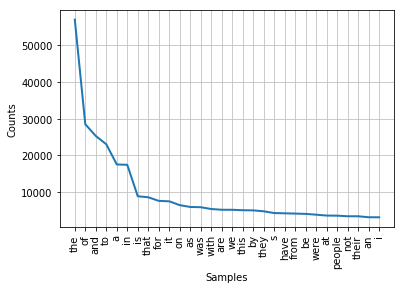

In [5]:
tot_fdist = FreqDist()
tot_without_stop_fdist = FreqDist()
doc_list = {}

json_file = open(JSON_FILE_NAME,"r")
documents = json.loads(json_file.read())
json_file.close()
for key, value in documents.items():
    fdist = FreqDist()
    for word in word_tokenize(normalize_string(value)):
        fdist[word.lower()] += 1
        tot_fdist[word.lower()] += 1
        if word.lower() not in stopwords.words('english'):
            tot_without_stop_fdist[word.lower()] += 1
    doc_list[key] = dict(fdist)
    
print("The 30 most common words:")
tot_fdist.plot(30)

The 30 most common words without stop words:


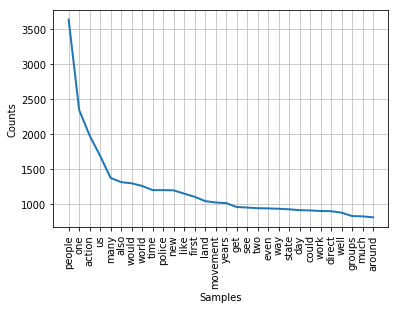

In [6]:
print("The 30 most common words without stop words:")
tot_without_stop_fdist.plot(30)

In [24]:
reversed_list = reverse_list(doc_list)

TF_IDF_computation = {}
for word in reversed_list:
    TF_IDF_computation[word] = tf_idf(reversed_list[word][1], len(reversed_list), len(doc_list), len(reversed_list[word][0]))

TF_IDF_computation = {k: v for k, v in sorted(TF_IDF_computation.items(), key=lambda item: item[1], reverse=True)}
trunk_TF_IDF = {}
print("Display top 30 words with IF-IDF computation:")
for element in list(TF_IDF_computation)[0:30]:
    trunk_TF_IDF[element] = TF_IDF_computation[element]
    print ("{} = {} ".format(element,  trunk_TF_IDF[element]))

Display top 100 words with IF-IDF computation:
i = 0.03122476880628265 
the = 0.027168897499075043 
p = 0.022353461193381045 
bayaka = 0.02055992374478318 
gm = 0.019617522950977403 
were = 0.018479443270079804 
isbn = 0.018295578044077616 
he = 0.017981308364222504 
are = 0.01795383038945386 
we = 0.017860076705958017 
women = 0.017562240152956824 
land = 0.01739579298017038 
species = 0.016958584141184823 
you = 0.01674545339349085 
police = 0.01665558194401923 
forest = 0.01645944732583645 
site = 0.01641474990730045 
was = 0.016389640023206094 
oil = 0.01637435514495421 
had = 0.01595405955263934 
cit = 0.015646970863962 
action = 0.015579247757094001 
ef = 0.01551379216620122 
prison = 0.015424777379704392 
uk = 0.015160674070372937 
camp = 0.01505480466669901 
book = 0.01497288058645243 
our = 0.014968584522912335 
op = 0.014635271310051762 
their = 0.014214276173840568 


The 30 first words found with a TF_IDF algorithm: 
 ['i', 'the', 'p', 'bayaka', 'gm', 'were', 'isbn', 'he', 'are', 'we', 'women', 'land', 'species', 'you', 'police', 'forest', 'site', 'was', 'oil', 'had', 'cit', 'action', 'ef', 'prison', 'uk', 'camp', 'book', 'our', 'op', 'their']


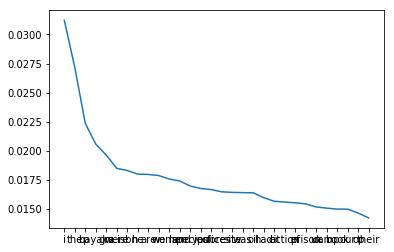

In [25]:
print("The 30 first words found with a TF_IDF algorithm: \n", list(trunk_TF_IDF.keys()))
plt.plot(trunk_TF_IDF.keys(), trunk_TF_IDF.values())
plt.show()

In [26]:
# save IF-IDF to file
file = open(IF_IDF_FILE_NAME,"w") 
file.write("word,score\n")
for element in list(TF_IDF_computation):
    file.write("{},{}\n".format(element,  TF_IDF_computation[element]))
file.close()